In [16]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
import skimage as sk
from skimage.io import imread, imshow
from skimage import exposure

from matplotlib.patches import Polygon

from fourier_scale_calibration import FourierSpaceCalibrator, windowed_fft

import tifffile

from moire_class import FourierAnalyzer, MoireAnalyzer

%matplotlib inline

# Find scale of images and angle of bilayer regions (not the maps) #

## scaling ##

### function definition ###

In [20]:
calibrator = FourierSpaceCalibrator('2nd-order-hexagonal', 
                                    lattice_constant=0.246, max_sampling=.05, min_sampling=.0015,
                                    normalize_azimuthal=True)

def calibrate(image):
    f = np.abs(np.fft.fftshift(windowed_fft(image)))
    calibrator.calibrate(image)

    spots = calibrator.get_spots()

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,8))
    ax1.imshow(gaussian_filter(image,2),cmap='gray')
    ax2.imshow(f ** .2,cmap='magma')
    ax2.plot(*spots.T,'wo', mfc='none', markersize=20)

    n = 100
    ax2.set_xlim(f.shape[0] // 2 - n, f.shape[0] // 2 + n)
    ax2.set_ylim(f.shape[1] // 2 - n, f.shape[1] // 2 + n);

    print('detected sampling (angstrom per pixel)', calibrator(image))
    return(calibrator(image))

### find scale ##

detected sampling (angstrom per pixel) 0.003996588859347327


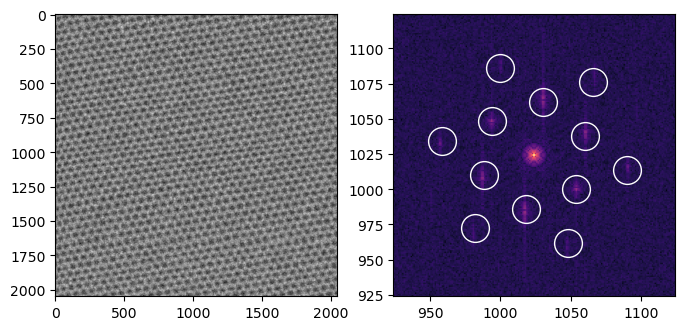

detected sampling (angstrom per pixel) 0.004100613395153466


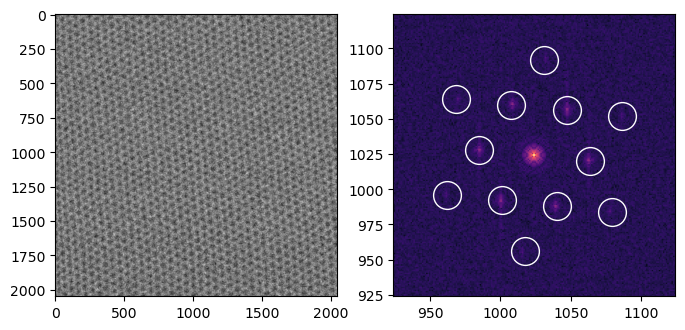

[0.003996588859347327, 0.004100613395153466]
mean nm per pixel for 8x8 2048px images: 0.004048601127250397


In [21]:
files = glob.glob('20230918_files/scale_graphene/*.tif')
calibration = []

for f in files:
    image = imread(f)
    cal = calibrate(image)
    plt.show()
    calibration.append(cal)

print(calibration)
mean_cal = np.mean(calibration)
print(f"mean nm per pixel for 8x8 2048px images: {mean_cal}")

In [22]:
rows = ['4x4', '8x8', '16x16', '32x32', '64x64', '128x128', '256x256', '512x512', '1024x1024', '2048x2048']
df_20230918 = pd.DataFrame(columns=['2048'], index=rows)

for i in range(-1,len(rows)-1):
    row = rows[i+1]
    df_20230918.loc[row] = [mean_cal*2**i]

df_20230918['4096'] = df_20230330['2048']/2

df_20230918.to_csv('non_interferometric/df_20230918.csv')

df_20230918

2048      4096
4x4        0.002024  0.000994
8x8        0.004049  0.001988
16x16      0.008097  0.003976
32x32      0.016194  0.007953
64x64      0.032389  0.015906
128x128    0.064778  0.031812
256x256    0.129555  0.063623
512x512     0.25911  0.127247
1024x1024  0.518221  0.254494
2048x2048  1.036442  0.508988

## Analyze Moiré patterns ##

In [2]:
## load the scale of the images calculated before ##
df_20230912 = pd.read_csv('20230912_files/scales.csv', index_col=0)
df_20230330 = pd.read_csv('non_interferometric/df_20230720.csv', index_col=0)
df_20230720 = pd.read_csv('non_interferometric/df_20230720.csv', index_col=0)

In [3]:
def get_scale(file, scale_df):
    with tifffile.TiffFile(file) as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            if name=='ImageDescription':
                tif_tags[name] = value
    image = tif.pages[0].asarray()
    pre_scale=float(tif_tags['ImageDescription'].split(',')[1].split(':')[-1])
    pre_scale = int(len(image)*pre_scale)

    scale = scale_df.loc[ f'{int(pre_scale)}x{int(pre_scale)}',str(len(image))]
    return scale

def get_size(file):
    with tifffile.TiffFile(file) as tif:
        tif_tags = {}
        
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            if name=='ImageDescription':
                tif_tags[name] = value
    image = tif.pages[0].asarray()
    pre_scale=float(tif_tags['ImageDescription'].split(',')[1].split(':')[-1])
    pre_scale = int(len(image)*pre_scale)
    return pre_scale

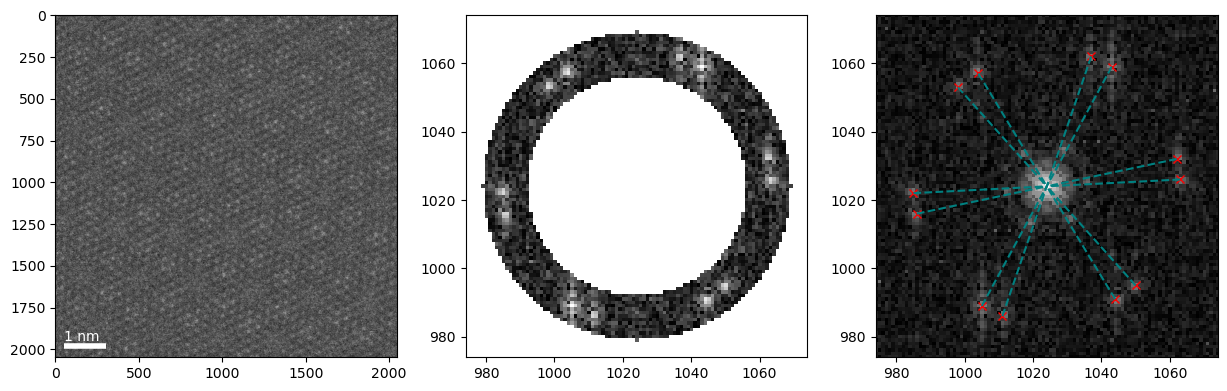

In [19]:
moire_files = glob.glob('/media/clara/PortableSSD/pnm/master_thesis/moire_study/20230330_1547/*.tif')

objects = []
for f in moire_files[2:3]:
    scale = get_scale(f, df_20230330)
    o = FourierAnalyzer(f, scale, size=get_size(f))
    o.find_angles()
    objects.append(o)

non_interferometric/moire_images/20230330_151718_moire_10.pdf
The mean angle in this region is 9.7°


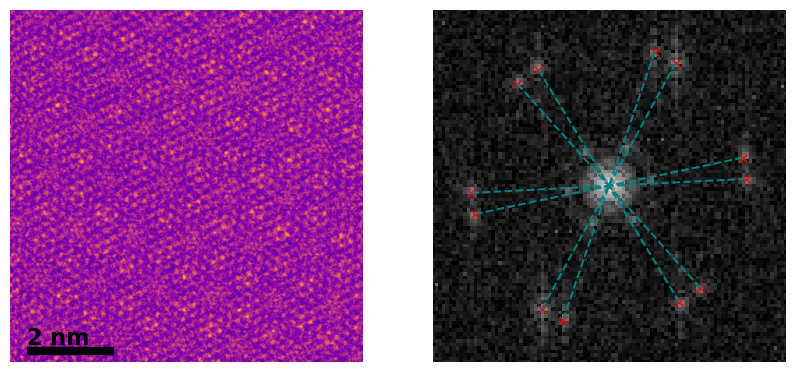

In [45]:
path = 'non_interferometric/moire_images/'

o.show_results(save=path, equalize=False, gaussian=3, alpha=1)
angles = o.angles
angle = np.mean(o.angles)

print(f"The mean angle in this region is {round(np.degrees(np.mean(angles)), 1)}°");

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

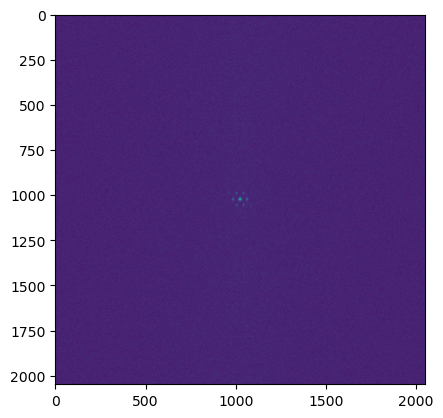

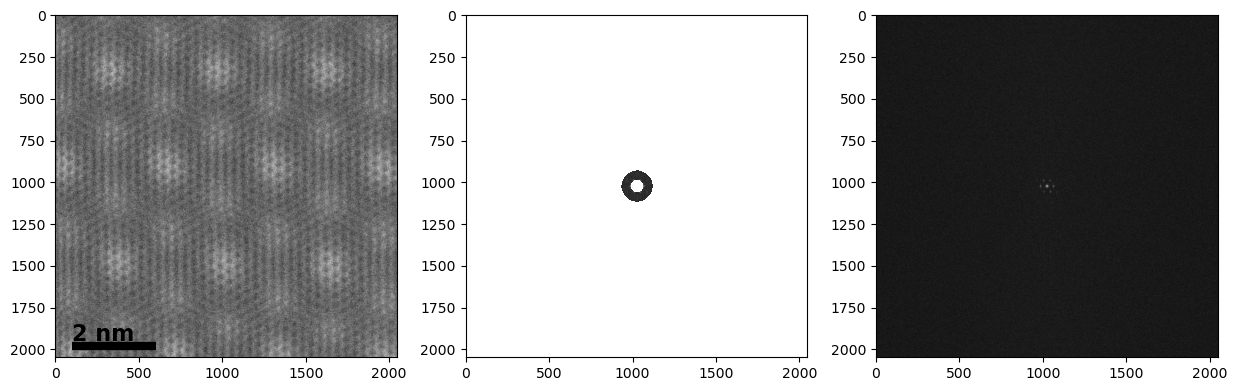

In [155]:
moire_files = glob.glob('/media/clara/PortableSSD/pnm/master_thesis/moire_study/20230912_1751/*.tif')

objects = []
for f in moire_files[2:3]:
    scale = get_scale(f, df_20230330)
    o = FourierAnalyzer(f, scale, size=get_size(f))
    o.find_angles()
    objects.append(o)

non_interferometric/moire_images/20230912_222251_moire_5.pdf
The mean angle in this region is 5.4°


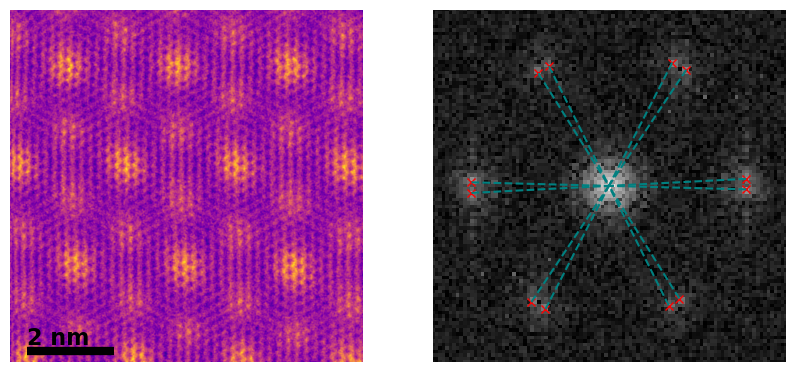

In [102]:
path = 'non_interferometric/moire_images/'

o.show_results(save=path, equalize=False, gaussian=3, alpha=1)
angles = o.angles
angle = np.mean(o.angles)

print(f"The mean angle in this region is {round(np.degrees(np.mean(angles)), 1)}°");

In [11]:
%matplotlib tk
moire_files = glob.glob('/media/clara/PortableSSD/pnm/master_thesis/moire_study/20230912_1751/*.tif')

objects = []
for f in moire_files[2:3]:
    scale = get_scale(f, df_20230330)
    objects.append(MoireAnalyzer(f,scale))

In [12]:
for o in objects:
    o.get_positions()
    o.get_angle()
    print(o.periodicity)
    print(np.degrees(o.angle))


2.892415808571381
4.874476651766451


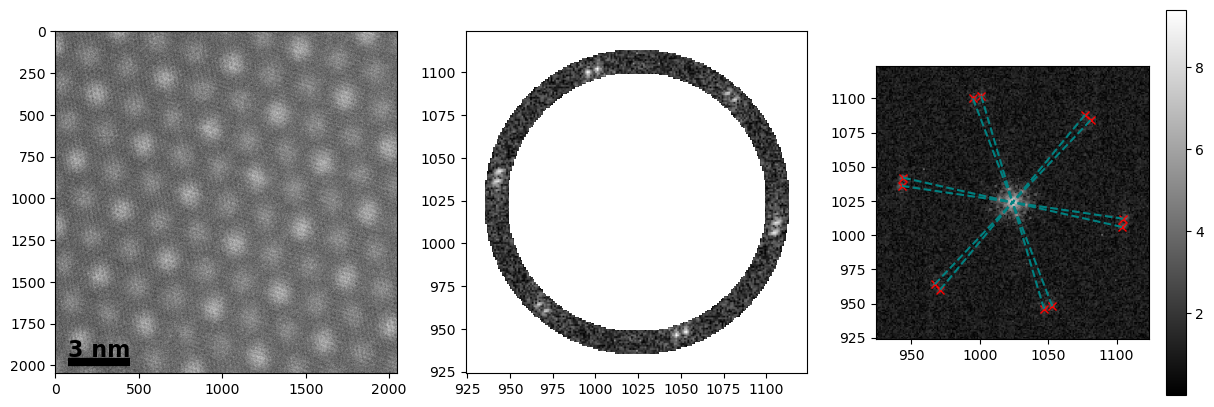

In [180]:
moire_files = glob.glob('/media/clara/PortableSSD/pnm/master_thesis/moire_study/20230912_1751/fov16/*.tif')

objects = []
for f in moire_files[1:2]:
    scale = get_scale(f, df_20230912)
    o = FourierAnalyzer(f, scale, size=get_size(f))
    o.find_angles()
    objects.append(o)

non_interferometric/moire_images/20230912_195911_moire_4.pdf
The mean angle in this region is 4.2°


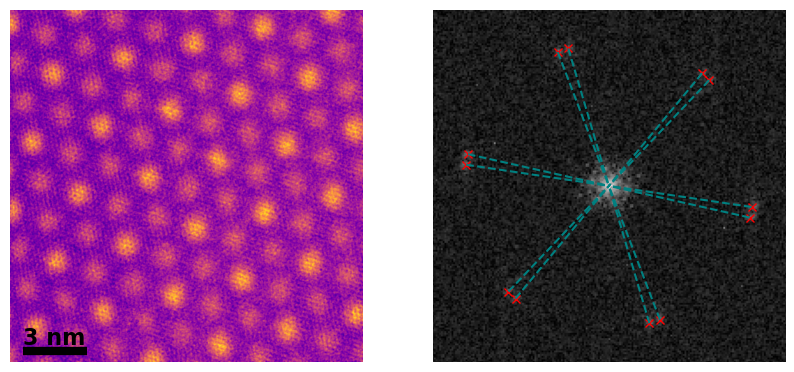

In [181]:
path = 'non_interferometric/moire_images/'

o.show_results(save=path, equalize=False, gaussian=3, alpha=1)
angles = o.angles
angle = np.mean(o.angles)

print(f"The mean angle in this region is {round(np.degrees(np.mean(angles)), 1)}°");

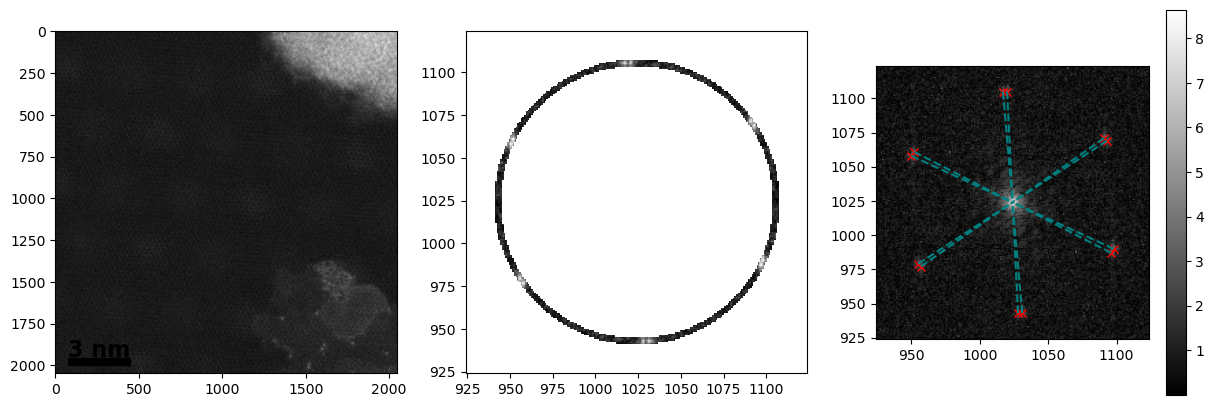

In [239]:
moire_files = glob.glob('/media/clara/PortableSSD/pnm/master_thesis/moire_study/20230330_1547/fov16/*.tif')

objects = []
for f in moire_files[0:1]:
    scale = get_scale(f, df_20230330)
    o = FourierAnalyzer(f, scale, size=get_size(f))
    o.find_angles()
    objects.append(o)

non_interferometric/moire_images/20230330_153133_moire_2.pdf
The mean angle in this region is 2.2°


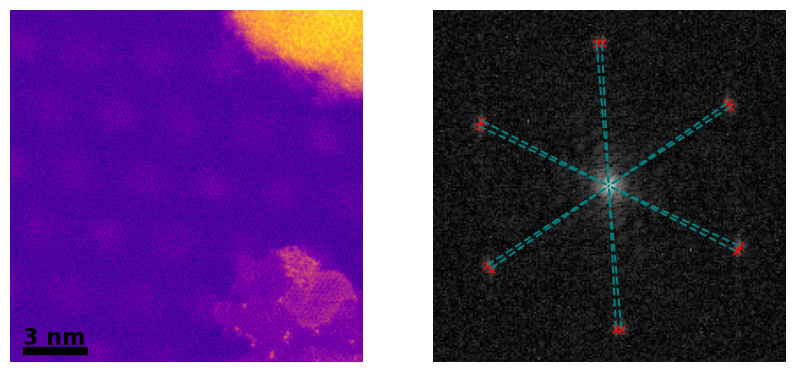

In [254]:
path = 'non_interferometric/moire_images/'

o.show_results(save=path, equalize=False, gaussian=3, alpha=6e-7)
angles = o.angles
angle = np.mean(o.angles)

print(f"The mean angle in this region is {round(np.degrees(np.mean(angles)), 1)}°");

/home/clara/miniconda3/envs/mt_analysis/lib/python3.9/site-packages/tifffile/tifffile.py:8904: UserWarning: <tifffile.TiffPage 0 @8> reading array from closed file
  warnings.warn(


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

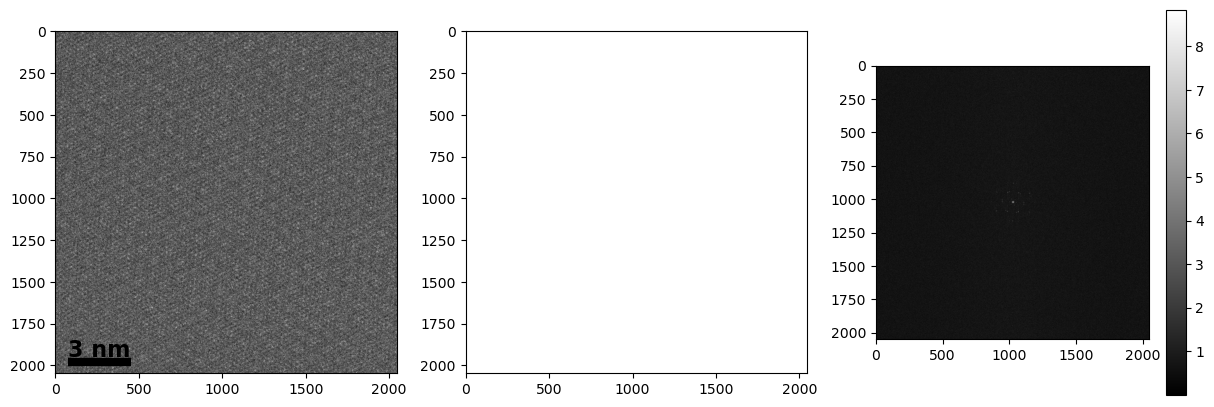

In [6]:
moire_files = glob.glob('/media/clara/PortableSSD/pnm/master_thesis/moire_study/20230330_1547/fov16/*.tif')

objects = []
for f in moire_files[1:2]:
    scale = get_scale(f, df_20230330)
    o = FourierAnalyzer(f, scale, size=get_size(f))
    o.find_angles()
    objects.append(o)

non_interferometric/moire_images/20230330_151740_moire_10.pdf
The mean angle in this region is 10.0°


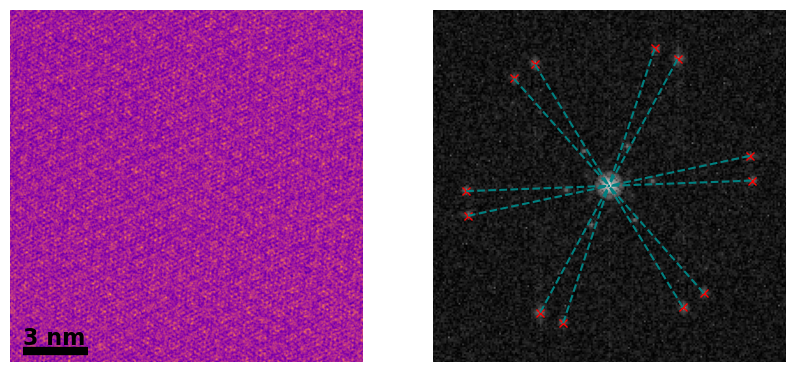

In [258]:
path = 'non_interferometric/moire_images/'

o.show_results(save=path, equalize=False, gaussian=3, alpha=1)
angles = o.angles
angle = np.mean(o.angles)

print(f"The mean angle in this region is {round(np.degrees(np.mean(angles)), 1)}°");

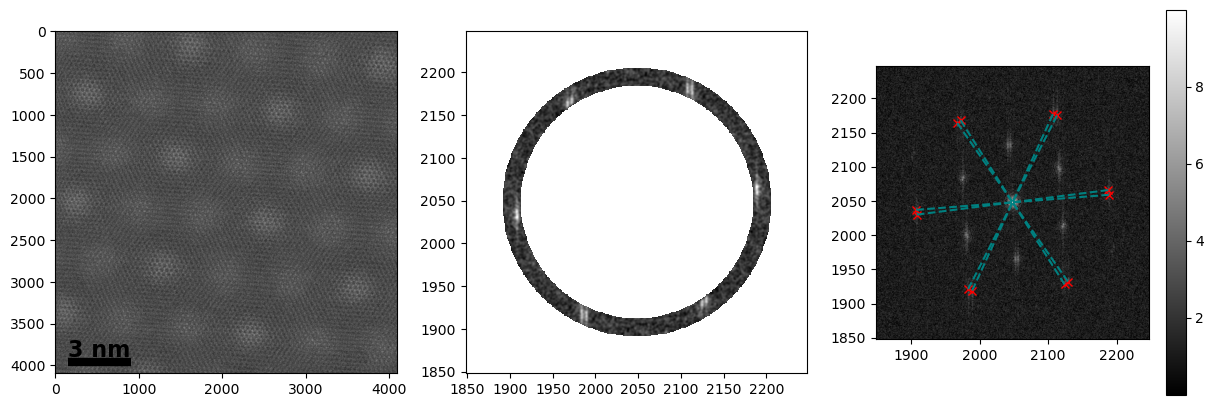

In [21]:
moire_files = glob.glob('/media/clara/PortableSSD/pnm/master_thesis/moire_study/20230330_1547/fov16/*.tif')

objects = []
for f in moire_files[2:3]:
    scale = get_scale(f, df_20230330)
    o = FourierAnalyzer(f, scale, size=get_size(f))
    o.find_angles()
    objects.append(o)

non_interferometric/moire_images/20230330_153754_moire_3.pdf
The mean angle in this region is 2.7°


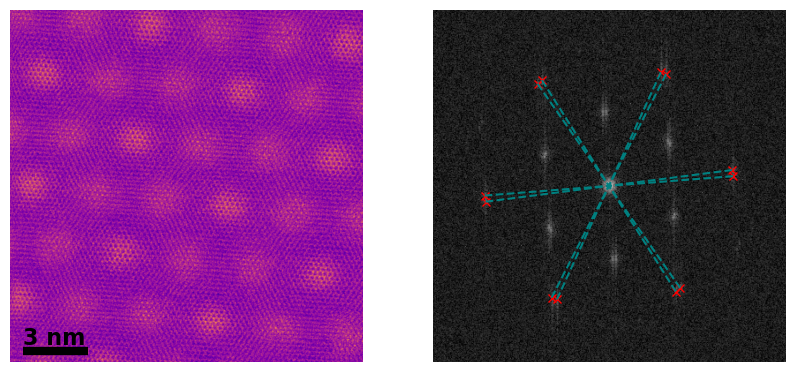

In [22]:
path = 'non_interferometric/moire_images/'

o.show_results(save=path, equalize=False, gaussian=3, alpha=1)
angles = o.angles
angle = np.mean(o.angles)

print(f"The mean angle in this region is {round(np.degrees(np.mean(angles)), 1)}°");

In [24]:
def side_len(theta):
    L = np.sqrt(3)*1.42*1e-10/(2*np.sin(theta/2))
    return L

In [29]:
side_len(np.radians(9.7))

1.4545164593701522e-09

In [ ]:
moire_files = glob.glob('images/20230330_1547_lasered_graphene_ml/moire/*.tif')
scale_df = df_20230330

objects = []

for f in moire_files:
    scale = get_scale(f, scale_df)
    objects.append(MoireAnalyzer(f,scale))